In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
from collections import defaultdict

set_config(transform_output="pandas")
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits, print_cv_info, print_split_info


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
import warnings; warnings.filterwarnings('ignore')


In [2]:
def SMAPE_1 (y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    y_true = np.array(y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [3]:
old_train = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/train.csv')
new_train = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting_new/revealed_test.csv')

old_test = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/test.csv')
sample_submission = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/sample_submission.csv')

train = pd.concat((old_train, new_train))
test = old_test[~old_test['first_day_of_month'].isin(new_train['first_day_of_month'])]

train['is_test'] = 0 ; test['is_test'] = 1

data = pd.concat((
        train,
        test)
        )\
    .reset_index(drop=True)\
    .assign(
        cfips = lambda df: df['cfips'].astype(str).str.zfill(5),
        date = lambda df: pd.to_datetime(df["first_day_of_month"]),
        mdensity_t0 = lambda df: df['microbusiness_density'],
        )\
    .sort_values(['cfips','date'], ascending=True)\
    .assign(
    
        state_i = lambda df: df['cfips'].apply(lambda x: x[:2]),
        county_i = lambda df: df['cfips'].apply(lambda x: x[2:]),
        
        year = lambda df: df['date'].dt.year,
        # month = lambda df: df['date'].dt.month,

        dcount = lambda df: df.groupby('cfips')['row_id'].cumcount(),
        
        mdensity_lag1 = lambda df: df.groupby('cfips')['mdensity_t0'].shift(1),
        mdensity_lag2 = lambda df: df.groupby('cfips')['mdensity_t0'].shift(2),
        mdensity_lag3 = lambda df: df.groupby('cfips')['mdensity_t0'].shift(3),
        
        target_0 = lambda df: np.nan_to_num(df['mdensity_t0']),
        target_1 = lambda df: np.nan_to_num(df['mdensity_t0']),
        target_2 = lambda df: np.nan_to_num(df['mdensity_t0']),

    

    )\
    .drop(['county','state'], axis='columns')

assert all(data.groupby('cfips')['county_i'].nunique() == 1)
assert all(data.groupby('cfips')['state_i'].nunique() == 1)
assert data['cfips'].nunique() == 3135 # there are 3135 county,state tuples
assert data['dcount'].nunique() == 47 # there are 47 series for each county state tuple
assert data.query('is_test==0')['dcount'].nunique() == 41 # there are 41 series in the train set. 
assert data.query('is_test==1')['dcount'].nunique() == 6  # there are 6 series in the test set. 


In [4]:
# adding census data
data_census = []
for year in range(2017,2022):
    COLS = ['GEO_ID','NAME','S0101_C01_026E']
    data_census_i = pd.read_csv(f'./data/raw/census_data_1/ACSST5Y{year}.S0101-Data.csv',usecols=COLS)
    data_census_i = data_census_i.iloc[1:]
    data_census_i['population'] = data_census_i['S0101_C01_026E'].astype('int')


    data_census_i['cfips'] = data_census_i.GEO_ID.apply(lambda x: f"{int(x.split('US')[-1]):05}" )
    data_census_i['year'] = year+2
    data_census.append(data_census_i[['cfips','year','population']])

data_census = pd.concat((data_census),axis='rows')


In [5]:
data = data.merge(data_census, on=['cfips','year'], how='left')

# Sample Data

In [6]:
# PARAMETERS
n_SPLITS = 5 
n_TRAIN_TRAIN_SIZE = 30
n_TRAIN_PERIOD = n_TRAIN_TRAIN_SIZE + 3 + n_SPLITS - 1 


TEST_DATES = list(np.sort(data.query('is_test==1')['date'].unique())[:3])
TEST_PERIOD = list(np.sort(data.query('is_test==1')['dcount'].unique())[:3])

TRAIN_PERIOD = list(np.sort(data.query('is_test==0')['dcount'].unique())[-n_TRAIN_PERIOD:])
TRAIN_DATES = list(np.sort(data.query('is_test==0')['date'].unique())[-n_TRAIN_PERIOD:])

LEAKAGE = ['mdensity_t0','active']
TARGETS = ['target_0', 'target_1', 'target_2']
FEATURES = ['population']
LAG_DENSITY = ['mdensity_lag1', 'mdensity_lag2', 'mdensity_lag3']

In [7]:
# data[data['dcount'].isin(TEST_PERIOD)].head()
# sample = data[data.cfips.isin(['01001'])] # sample = data[data.cfips.isin(['01001','56045'])]
sample = data.copy()
sample.loc[sample.is_test==1,TARGETS]  = np.nan
sample = sample.set_index(['date','cfips']).sort_index().loc[TRAIN_DATES+TEST_DATES]
sample = sample[['dcount','county_i'] + LAG_DENSITY + TARGETS + FEATURES+ LEAKAGE]
sample_train= sample.query("dcount in @TRAIN_PERIOD") ; sample_test= sample.query("dcount in @TEST_PERIOD")
train_X = sample_train.drop(TARGETS,axis='columns') ; train_y = sample_train[TARGETS]
test_X = sample_test.drop(TARGETS,axis='columns') ; test_y = sample_test[TARGETS]


# EDA

In [8]:
from tools import plot_two_way_axis

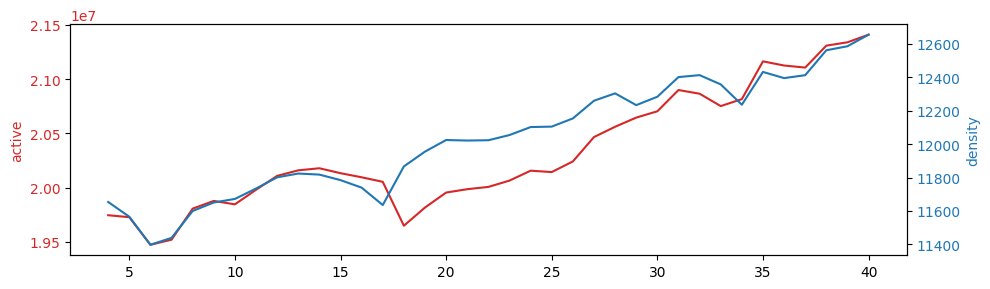

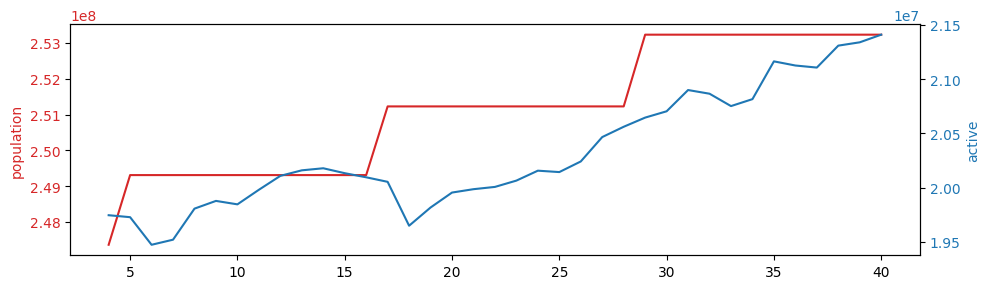

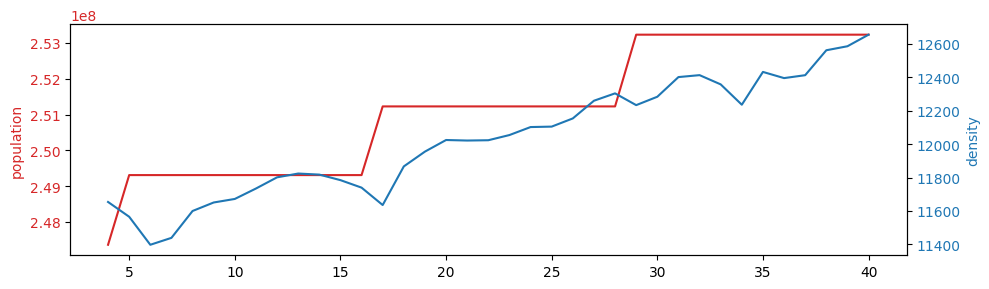

In [10]:
data_active = train_X.reset_index().groupby(['dcount'])['active'].sum()
data_pop = train_X.reset_index().groupby(['dcount'])['population'].sum()
data_density = train_X.reset_index().groupby(['dcount'])['mdensity_t0'].sum()
x_axis = data_active.index

data_active.shape,data_pop.shape,data_density.shape

plot_two_way_axis(x_axis, data_active,'active', data_density,'density')
plot_two_way_axis(x_axis, data_pop,'population', data_active,'active')
plot_two_way_axis(x_axis, data_pop,'population', data_density,'density')



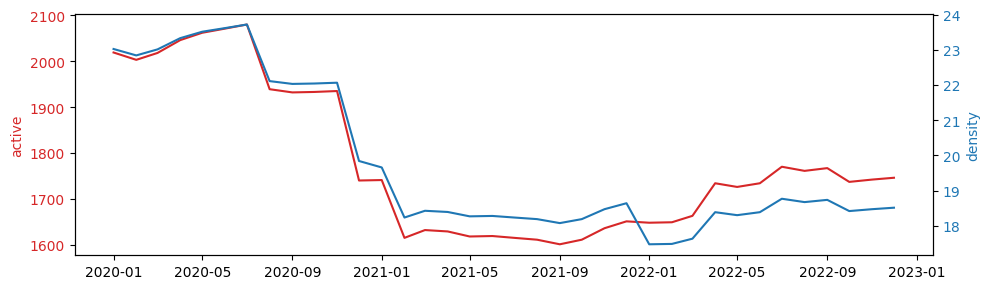

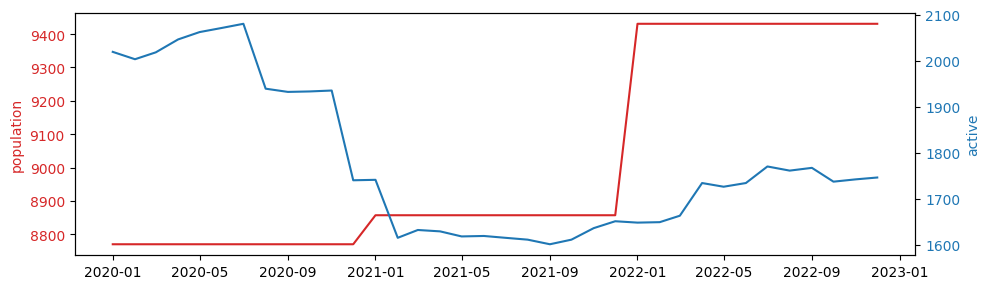

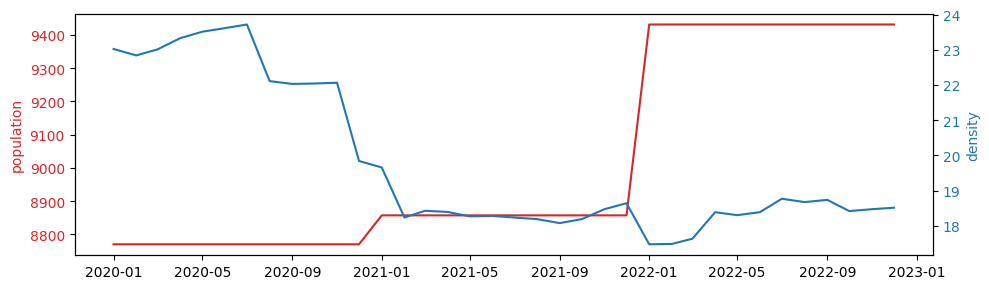

In [245]:
id_sample= data.groupby('cfips')['population'].std().sort_values(ascending=False)[:20]
id_sample= (data_census.groupby('cfips')['population'].std()/data_census.groupby('cfips')['population'].mean()).sort_values(ascending=False)[:20]
random_id = np.random.choice(id_sample.index)


sample_data = train_X.query('(cfips == @random_id) and (dcount  >= 5)')
x_axis = sample_data['active'].droplevel(1).index
data1 = sample_data['active'].droplevel(1).values
data2 = sample_data['mdensity_t0'].droplevel(1).values
data3 = sample_data['population'].droplevel(1).values

plot_two_way_axis(x_axis, data1,'active', data2,'density')
plot_two_way_axis(x_axis, data3,'population', data1,'active')
plot_two_way_axis(x_axis, data3,'population', data2,'density')

